In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Exercise 3

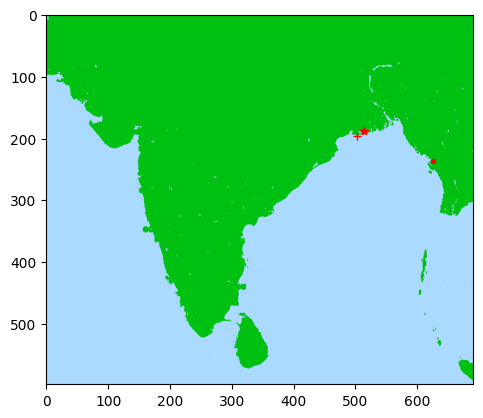

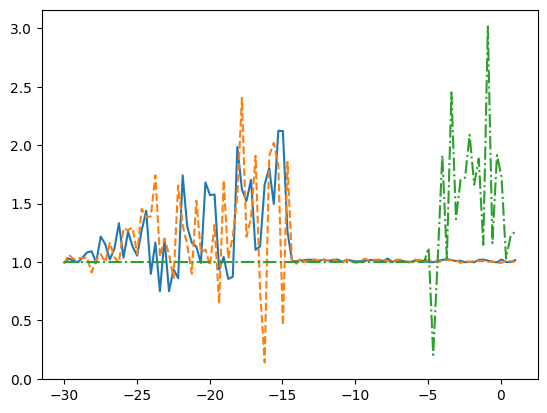

In [59]:
mat = scipy.io.loadmat('bengali_cleanup.mat')
A = plt.imread('bengali_map.png')

timeseries = mat['timeseries']
tv = mat['tv'][0]
x_coords = mat['x_coords']
y_coords = mat['y_coords']
jv = [101, 279, 9]  # Since Python index from 0 we subtract 1 on every element

plt.plot(y_coords[jv[0]],x_coords[jv[0]], 'r*', y_coords[jv[1]],x_coords[jv[1]], 'r+', y_coords[jv[2]],x_coords[jv[2]], 'r.')
plt.imshow(A)
plt.figure()
plt.plot()
plt.plot(tv, timeseries[jv[0],:], '-', tv,timeseries[jv[1],:], '--',tv,timeseries[jv[2],:], '-.')